# Logistic Regression Laplace Approximation

In [1]:
# Prior
import torch
import matplotlib.pyplot as plt

prior_mean = torch.tensor([0.0, 0.0])
prior_cov = torch.tensor([[1.,0.],[0.,1.]])

def multivariate_normal(prior_mean, prior_cov):
    return torch.distributions.MultivariateNormal(prior_mean, prior_cov)
prior = multivariate_normal(prior_mean, prior_cov)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


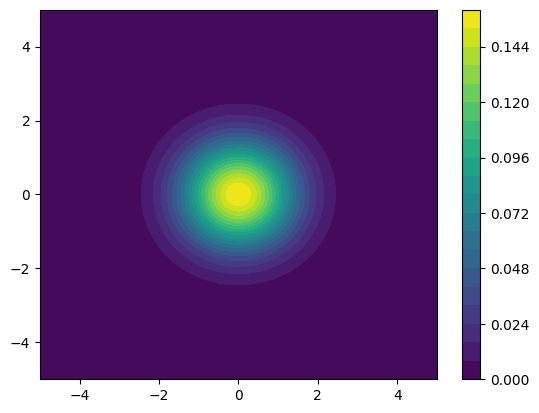

In [2]:
# Plot contour plot of the distribution
def plot_contour_dist(dist, colour=None, alpha=None, linestyle=None, x=None, y=None, title=None):
    if x is None:
        x = torch.linspace(-5, 5, 1000)
    if y is None:
        y = torch.linspace(-5, 5, 1000)
    X, Y = torch.meshgrid(x, y)
    Z = torch.stack([X, Y], dim=-1)
    z = dist.log_prob(Z).exp()
    z = z.detach().numpy()
    if colour is None:
        colour = 'viridis'
    if alpha is None:
        alpha = 1
    if linestyle is None:
        linestyle = 'solid'
    plt.contourf(X, Y, z , levels = 20, cmap = colour, alpha = alpha, linestyles = linestyle)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()

plot_contour_dist(prior)


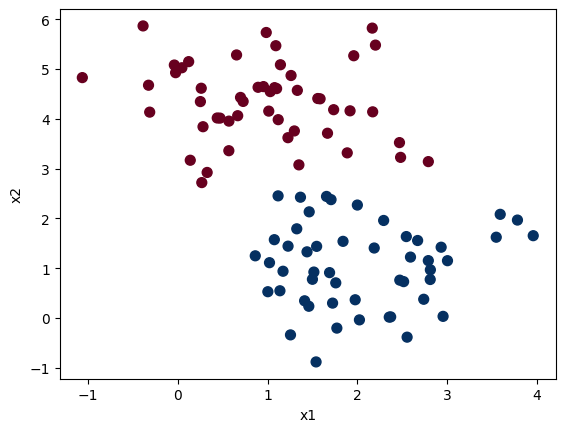

In [3]:
# Create a dataset of 5 points for a classification problem to be solved by logistic regression

import numpy as np
from sklearn.datasets import make_blobs

n_samples = 100
# Generate dataset

def generate_classification_dataset(n_samples=100):
    X, y = make_blobs(
        n_samples=n_samples, centers=2, n_features=2, random_state=0, cluster_std=0.8
    )
    return X, y

# Visualise dataset

def plot_classification_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="RdBu")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

X, y = generate_classification_dataset(n_samples)
plot_classification_dataset(X, y)

In [4]:
X = X.astype(np.float32)

In [5]:
torch.tensor(y)
y = y.astype(float)

In [6]:
# likelihood

def forward(X, theta):
    X = torch.tensor(X)
    return torch.sigmoid(X @ theta)
    # return torch.sigmoid(X*theta[1] + theta[0])

def log_likelihood(theta, X=X, y=y):
    p = forward(X, theta)
    dist = torch.distributions.Bernoulli(probs=p)
    return dist.log_prob(torch.tensor(y)).sum()

In [7]:
def log_posterior(theta, prior, X=X, y=y):
    return log_likelihood(theta, X, y) + prior.log_prob(theta)

In [8]:
# Calculate theta map

def map(prior, X=X, y=y):
    theta_map = torch.tensor([0.,0.], requires_grad=True)
    optimizer = torch.optim.Adam([theta_map], lr=0.1)
    for i in range(1000):
        optimizer.zero_grad()
        loss = -log_posterior(theta_map, prior, X, y)
        loss.backward()
        optimizer.step()
    return theta_map

theta_map = map(prior)
print('theta_map:', theta_map)

theta_map: tensor([ 2.1446, -1.4278], requires_grad=True)


In [67]:
# Calculate theta mle

def mle(X=X, y=y):
    theta_mle = torch.tensor([0.,0.], requires_grad=True)
    optimizer = torch.optim.Adam([theta_mle], lr=0.1)
    for i in range(1000):
        optimizer.zero_grad()
        loss = -log_likelihood(theta_mle, X, y)
        loss.backward()
        optimizer.step()
    return theta_mle

theta_mle = mle()
print('theta_mle:', theta_mle)

theta_mle: tensor([ 3.3755, -2.2146], requires_grad=True)


/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_41321/120313189.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


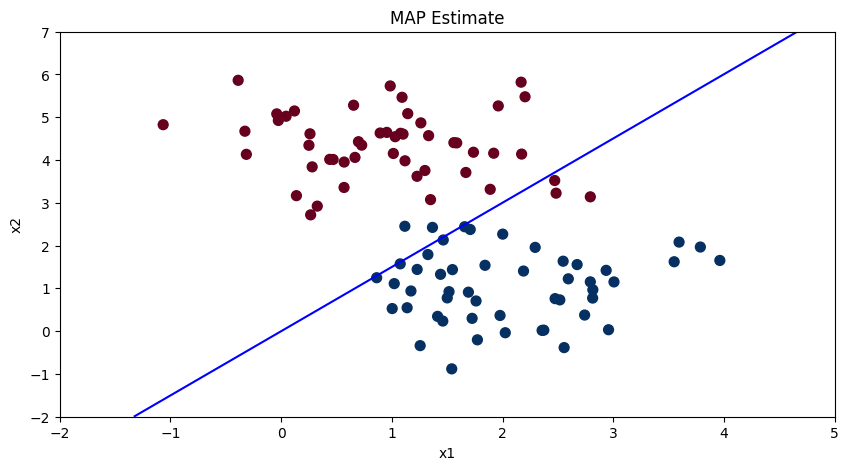

In [9]:
# get the decision boundary line from the map estimate
import matplotlib.patches as mpatches

def plot_map_estimate_decision_boundary(theta_map, X=X, y=y):

    fig = plt.figure(figsize=(10, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="RdBu")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('MAP Estimate')
    x1 = torch.linspace(-2, 5, 1000)
    x2 = torch.linspace(-2, 7, 1000)
    X1, X2 = torch.meshgrid(x1, x2)
    Z = torch.stack([X1, X2], dim=-1)
    z_map = forward(Z, theta_map).detach().numpy()
    plt.contour(X1, X2, z_map, levels=[0.5], colors='blue')
    plt.show()

plot_map_estimate_decision_boundary(theta_map)

In [57]:
def hessian_bivariate_normal(nll, mode):
    hessian = torch.autograd.functional.hessian(nll, mode)
    return torch.inverse(hessian)


In [58]:
nll = lambda theta: -log_likelihood(theta, X, y)
posterior_approx_cov = hessian_bivariate_normal(nll, theta_map)

In [59]:
laplace_dist = multivariate_normal(theta_map, posterior_approx_cov)
theta_sample_laplace = laplace_dist.sample()
print('theta_sample_laplace:', theta_sample_laplace)

theta_sample_laplace: tensor([ 1.7110, -1.2647])


In [68]:

def plot_theta_decision_boundary_compare(theta_1, theta_2, theta_3,  X=X, y=y):

    fig = plt.figure(figsize=(10, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="RdBu")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Theta Estimate')
    x1 = torch.linspace(-2, 5, 1000)
    x2 = torch.linspace(-2, 7, 1000)
    X1, X2 = torch.meshgrid(x1, x2)
    Z = torch.stack([X1, X2], dim=-1)
    z_map = forward(Z, theta_1).detach().numpy()
    z_map_2 = forward(Z, theta_2).detach().numpy()
    z_map_3 = forward(Z, theta_3).detach().numpy()
    plt.contour(X1, X2, z_map, levels=[0.5], colors='blue')
    plt.contour(X1, X2, z_map_2, levels=[0.5], colors='red')
    plt.contour(X1, X2, z_map_3, levels=[0.5], colors='green')

    plt.show()


In [65]:
theta_map

tensor([ 2.1446, -1.4278], requires_grad=True)

/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_41321/120313189.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


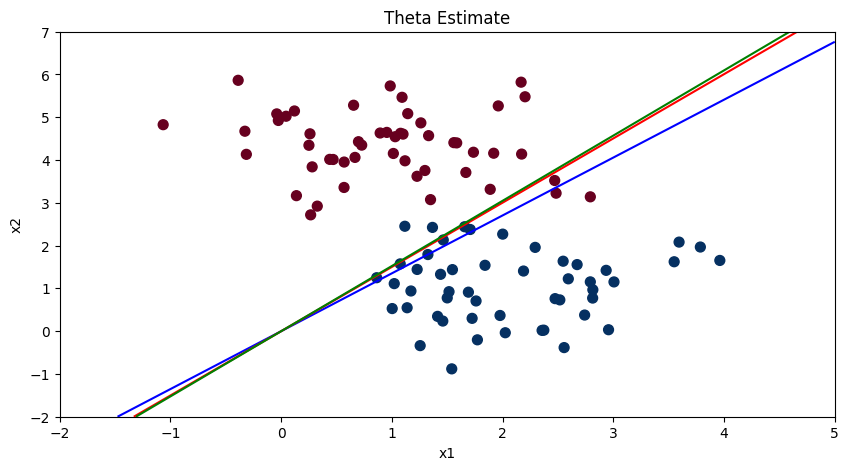

In [69]:
plot_theta_decision_boundary_compare(theta_sample_laplace, theta_map, theta_mle)

In [78]:
theta_samples_posterior = laplace_dist.sample((10,))
theta_samples_posterior

tensor([[ 1.9336, -1.2106],
        [ 2.3942, -1.5355],
        [ 1.9173, -1.3646],
        [ 1.6283, -1.3628],
        [ 2.0293, -1.5335],
        [ 1.8352, -1.2569],
        [ 2.3378, -1.5165],
        [ 2.6491, -1.7481],
        [ 1.8887, -1.2710],
        [ 1.2867, -1.2082]])

In [84]:
# get some new data
X_new, y_new = generate_classification_dataset(n_samples=5)
X_new = X_new.astype(np.float32)
y_new = y_new.astype(float)
X_new, y_new

(array([[0.893695 , 4.632266 ],
        [2.1705024, 2.0610824],
        [2.6640978, 0.9950037],
        [1.7363408, 4.1827016],
        [2.4703164, 3.521965 ]], dtype=float32),
 array([0., 1., 1., 0., 0.]))

/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_41321/120313189.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


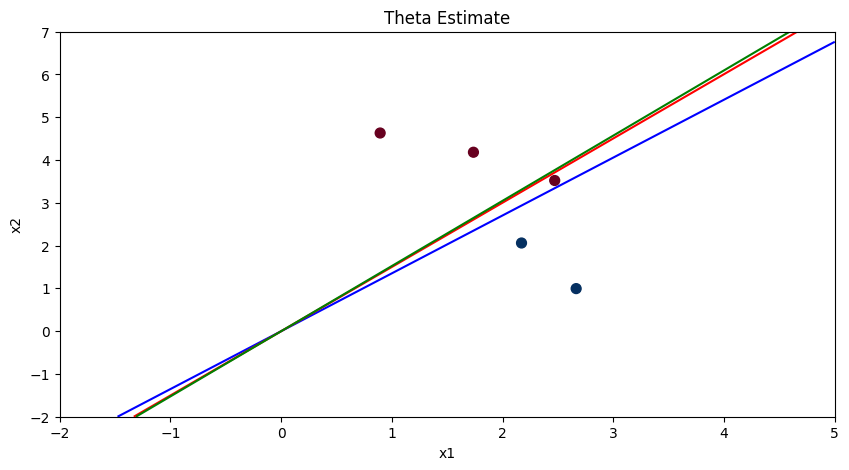

In [92]:
# plot X_new, y_new data along with the decision boundary
plot_theta_decision_boundary_compare(theta_sample_laplace, theta_map, theta_mle, X=X_new, y=y_new)

In [91]:
# get the posterior predictive distribution
def posterior_predictive(theta_samples, i, X_new, y_new):
    p = forward(X_new, theta_samples[i])
    # print(p)
    print(y_new)
    dist = torch.distributions.Bernoulli(probs=p)
    return dist.sample()

posterior_predictive_dist=[]
for i in range(10):
    posterior_predictive_dist.append(posterior_predictive(theta_samples_posterior, i, X_new, y_new))
# posterior_predictive_dist = posterior_predictive(theta_samples_posterior, X_new, y_new)
posterior_predictive_dist


[0. 1. 1. 0. 0.]
[0. 1. 1. 0. 0.]
[0. 1. 1. 0. 0.]
[0. 1. 1. 0. 0.]
[0. 1. 1. 0. 0.]
[0. 1. 1. 0. 0.]
[0. 1. 1. 0. 0.]
[0. 1. 1. 0. 0.]
[0. 1. 1. 0. 0.]
[0. 1. 1. 0. 0.]


[tensor([0., 1., 1., 0., 0.]),
 tensor([0., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 0., 0.]),
 tensor([0., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 1., 1.]),
 tensor([0., 0., 1., 0., 1.]),
 tensor([0., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 0., 1.]),
 tensor([0., 1., 1., 0., 0.])]

tensor([0., 1., 1.])
torch.Size([1000, 1000, 2]) torch.Size([3])


/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_41321/120313189.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


RuntimeError: size mismatch, got 1000000, 1000000x2,3

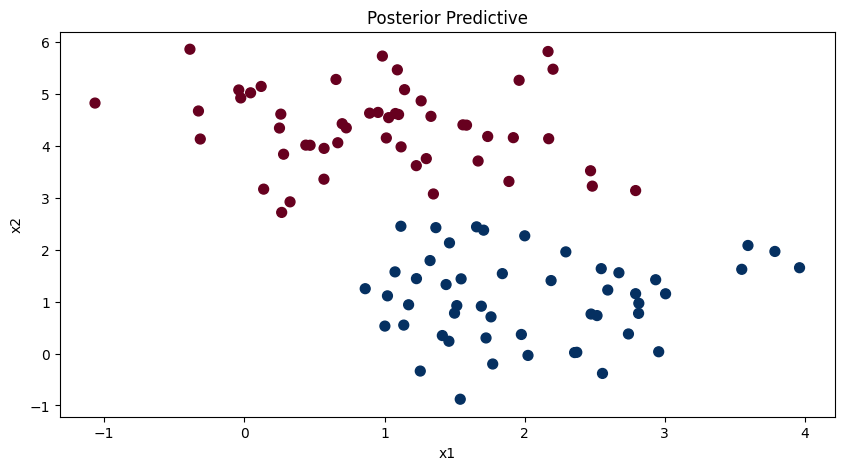

In [77]:
# get the posterior predictive distribution

def posterior_predictive(theta, X=X, y=y):
    p = forward(X, theta)
    dist = torch.distributions.Bernoulli(probs=p)
    return dist.sample()

def plot_posterior_predictive(theta, X=X, y=y):
    fig = plt.figure(figsize=(10, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="RdBu")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Posterior Predictive')
    # print(Z)
    # print(theta)
    z_map = forward(Z, theta).detach().numpy()
    plt.contour(X1, X2, z_map, levels=[0.5], colors='blue')
    plt.show()

X_new = torch.tensor([[0.5, 0.5], [1.5, 1.5], [2.5, 2.5]])
theta_sample = posterior_predictive(theta_map, X=X_new)
print(theta_sample)
plot_posterior_predictive(theta_sample, X=X_new)


In [55]:
def laplace_approx_bivariate_normal(mode):
    nll = lambda theta: -log_likelihood(theta)
    scale = hessian_bivariate_normal(nll, mode)
    # print("The scale in laplace_approx_bivariate_normal is ",scale)
    # print("The mode in laplace_approx_bivariate_normal is ",mode)
    # print("The scale in laplace_approx_bivariate_normal is ",scale)
    laplace_dist = torch.distributions.MultivariateNormal(mode, covariance_matrix=scale)
    return laplace_dist

def plot_bivariate_normal_laplace(prior_mean1, prior_mean2, prior_cov11, prior_cov12, prior_cov22):
    prior_mean = torch.tensor([prior_mean1, prior_mean2])
    prior_cov = torch.tensor([[prior_cov11, prior_cov12], [prior_cov12, prior_cov22]])
    dist = torch.distributions.MultivariateNormal(prior_mean, prior_cov)
    # params_init = torch.tensor([0.0, 0.0], requires_grad=True)
    params_mode = map(dist)
    print(params_mode)
    laplace_dist = laplace_approx_bivariate_normal(params_mode)
    plot_contour_dist(dist, colour='Reds', title='Prior')
    plot_contour_dist(laplace_dist, colour='plasma', linestyle='--', title='Laplace Approximation')
    plt.show()

In [56]:
from ipywidgets import interact

interact(plot_bivariate_normal_laplace, prior_mean1=(-5,5,0.1), prior_mean2=(-5,5,0.1), prior_cov11=(0.1,5,0.1), prior_cov12=(-5,5,0.1), prior_cov22=(0.1,5,0.1))

interactive(children=(FloatSlider(value=0.0, description='prior_mean1', max=5.0, min=-5.0), FloatSlider(value=…

<function __main__.plot_bivariate_normal_laplace(prior_mean1, prior_mean2, prior_cov11, prior_cov12, prior_cov22)>

In [32]:
# approximate the denominator of posterior using monte carlo sampling

num_samples = 10000
# Number of Monte Carlo samples
def monte_carlo_approximation(prior, num_samples=10000):

    # Initialize a variable to store the log-sum-exp of function values
    log_posterior_values = []

    # Generate Monte Carlo samples and estimate the log of the integral
    for _ in range(num_samples):
        # Sample from a proposal distribution (e.g., a multivariate normal)
        theta_sample = torch.tensor(prior.sample())
        # print(theta_sample)
        # Calculate the unnormalized log posterior value at the theta_sample
        log_posterior_value = log_posterior(theta_sample, prior)
        # print(log_posterior_value)
        log_posterior_values.append(log_posterior_value)
        # Update the log integral using logsumexp
        # log_integral = torch.logsumexp(torch.tensor([log_integral, log_posterior_value]), dim=0)
        # print(log_integral)

    log_denominator = torch.logsumexp(torch.stack(log_posterior_values), dim=0)
    # The estimated integral (denominator) is e^log_integral
    estimated_denominator = torch.exp(log_denominator - torch.log(torch.tensor(num_samples, dtype=torch.float32)))

    return estimated_denominator

estimated_denominator = monte_carlo_approximation(prior, num_samples)
print("Estimated Denominator (Monte Carlo):", estimated_denominator.item())

/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_41321/3272238624.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_sample = torch.tensor(prior.sample())


Estimated Denominator (Monte Carlo): 3.0037772316610807e-12


In [46]:
# Plot contour plot of the distribution
def plot_contour_dist_normalized(dist, denominator, colour=None, alpha=None, linestyle=None, x=None, y=None, title=None):
    if x is None:
        x = torch.linspace(-5, 5, 1000)
    if y is None:
        y = torch.linspace(-5, 5, 1000)
    X, Y = torch.meshgrid(x, y)
    Z = torch.stack([X, Y], dim=-1)
    z = dist.log_prob(Z).exp()
    z = z.detach().numpy()
    z = z/denominator
    if colour is None:
        colour = 'viridis'
    if alpha is None:
        alpha = 1
    if linestyle is None:
        linestyle = 'solid'
    plt.contourf(X, Y, z , levels = 20, cmap = colour, alpha = alpha, linestyles = linestyle)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()


In [44]:
def plot_bivariate_normal_laplace_mc(prior_mean1, prior_mean2, prior_cov11, prior_cov12, prior_cov22):
    prior_mean = torch.tensor([prior_mean1, prior_mean2])
    prior_cov = torch.tensor([[prior_cov11, prior_cov12], [prior_cov12, prior_cov22]])
    dist = torch.distributions.MultivariateNormal(prior_mean, prior_cov)
    # params_init = torch.tensor([0.0, 0.0], requires_grad=True)
    params_mode = map(dist)
    print(params_mode)
    laplace_dist = laplace_approx_bivariate_normal(params_mode)
    denominator = monte_carlo_approximation(prior).item()
    print(denominator)
    # posterior_approx_dist = laplace_dist/denominator

    plot_contour_dist(dist, colour='Reds', title='Prior')
    plot_contour_dist(laplace_dist, colour='plasma', linestyle='--', title='Unnormalized Laplace Approximation')
    plot_contour_dist_normalized(laplace_dist, denominator, colour='plasma', linestyle='--', title='Laplace Approximation')
    plt.show()

In [45]:
from ipywidgets import interact

interact(plot_bivariate_normal_laplace_mc, prior_mean1=(-5,5,0.1), prior_mean2=(-5,5,0.1), prior_cov11=(0.1,5,0.1), prior_cov12=(-5,5,0.1), prior_cov22=(0.1,5,0.1))

interactive(children=(FloatSlider(value=0.0, description='prior_mean1', max=5.0, min=-5.0), FloatSlider(value=…

<function __main__.plot_bivariate_normal_laplace_mc(prior_mean1, prior_mean2, prior_cov11, prior_cov12, prior_cov22)>